# Segmentez des clients d'un site e-commerce

# Notebook Modelisation
Dans le premier notebook, l'analyse de données, le feature engineering et le découpage en 6 datasets avec des horizons temporels différents a été effectué.

Dans ce notebook les dimensions vont être réduites et les données segmentées en utilisant différents modèles (kmeans, clustering hierarchique et DBSCAN).

Pour terminer, une fréquence idéale de segmentation sera proposée et inclut dans un contrat de maintenance.

In [60]:
# Importer les librairies

from google.colab import files
import io
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
palette = sns.color_palette("bright", 10)

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 

from sklearn.decomposition import PCA 
from sklearn import decomposition 
from sklearn.manifold import TSNE 

import sklearn as sk
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import sys
import time

##  Importer les data sets avec les  1, 2, 3, 4, 5 , 6 et 24 mois de données

In [45]:
data_to_load = files.upload()
df = pd.read_csv(io.BytesIO(data_to_load["df24.csv"]))

Saving df24.csv to df24 (1).csv


In [14]:
data_to_load = files.upload()
df_1m = pd.read_csv(io.BytesIO(data_to_load["df1.csv"]))

Saving df1.csv to df1 (1).csv


In [15]:
data_to_load = files.upload()
df_2m = pd.read_csv(io.BytesIO(data_to_load["df2.csv"]))

Saving df2.csv to df2 (1).csv


In [16]:
data_to_load = files.upload()
df_3m = pd.read_csv(io.BytesIO(data_to_load["df3.csv"]))

Saving df3.csv to df3 (1).csv


In [17]:
data_to_load = files.upload()
df_4m = pd.read_csv(io.BytesIO(data_to_load["df4.csv"]))

Saving df4.csv to df4 (1).csv


In [21]:
data_to_load = files.upload()
df_5m = pd.read_csv(io.BytesIO(data_to_load["df5.csv"]))

Saving df5.csv to df5 (2).csv


In [19]:
data_to_load = files.upload()
df_6m = pd.read_csv(io.BytesIO(data_to_load["df6.csv"]))

Saving df6.csv to df6 (1).csv


In [9]:
# Reduction de la memoire pour les calculs par transformation des float64 en float16

df_flt16 = df.astype('float16')
memoire_originale = sys.getsizeof(df)
memoire_transforme = sys.getsizeof(df_flt16)
delta_memoire = memoire_originale - memoire_transforme
delta_memoire

print('Espace mémoire originale :', sys.getsizeof (df) )
print('Espace mémoire transformée :', sys.getsizeof (df_flt16) )
print('Economie de mémoire :', delta_memoire )

Espace mémoire originale : 185696
Espace mémoire transformée : 46544
Economie de mémoire : 139152


La mémoire du df principal est descendue de 1.8G0 à  460MO, soit une économie de presque 1.4 GO.

In [46]:
df.shape

(93396, 8)

In [48]:
df.isna().mean()

recency                 0.0
frequency               0.0
payment_median          0.0
price_median            0.0
installments_median     0.0
freight_value_median    0.0
review_median           0.0
photos_qty_median       0.0
dtype: float64

# 1. PREPROCESSING

## Transformation en float16 pour réduire la taille

In [22]:
df_flt16_1m = df_1m.astype('float16')
df_flt16_2m = df_2m.astype('float16')
df_flt16_3m = df_3m.astype('float16')
df_flt16_4m = df_4m.astype('float16')
df_flt16_5m = df_5m.astype('float16')
df_flt16_6m = df_6m.astype('float16')

## Standard Scaling

In [32]:
scaler = MinMaxScaler()
X_std = scaler.fit_transform(df_flt16)

scaler1 = MinMaxScaler()
X_std1 = scaler1.fit_transform(df_flt16_1m)

scaler2 =MinMaxScaler()
X_std2 = scaler2.fit_transform(df_flt16_2m)

scaler3 = MinMaxScaler()
X_std3 = scaler3.fit_transform(df_flt16_3m)

scaler4 = MinMaxScaler()
X_std4 = scaler4.fit_transform(df_flt16_3m)

scaler5 = MinMaxScaler()
X_std5 = scaler5.fit_transform(df_flt16_5m)

scaler6 = MinMaxScaler()
X_std6 = scaler6.fit_transform(df_flt16_6m)

# Imputation des NAN

In [50]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp = imputer.fit_transform(X_std)

imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp1 = imputer1.fit_transform(X_std1)

imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp2 = imputer2.fit_transform(X_std2)

imputer3 = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp3 = imputer3.fit_transform(X_std3)

imputer4 = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp4 = imputer4.fit_transform(X_std4)

imputer5 = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp5 = imputer5.fit_transform(X_std5)

imputer6 = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp6 = imputer6.fit_transform(X_std6)

# 2. REDUCTION DE DIMENSION

## PCA

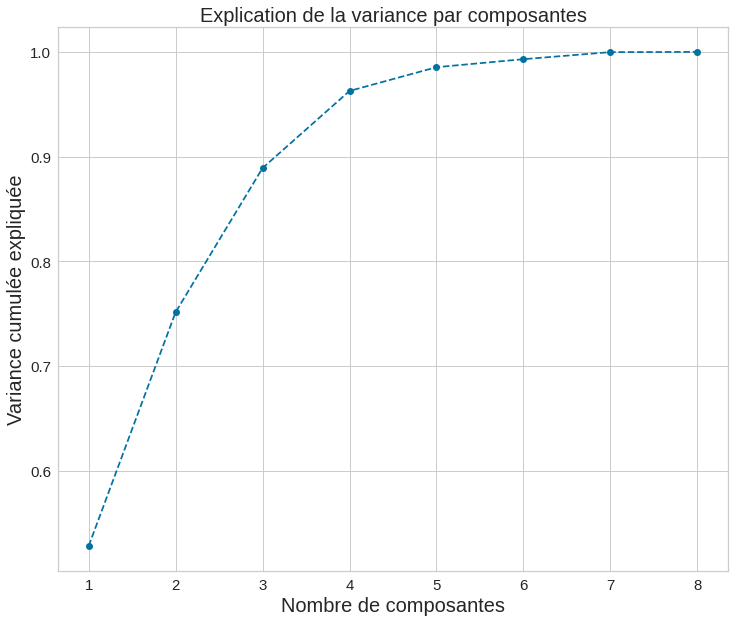

In [51]:
# Calcul les 10 premières composantes principales

pca = decomposition.PCA(n_components=8)
pca.fit(X_imp)

# Scree plot pour afficher la variance cumulée expliquée selon les composantes principales

plt.figure(figsize= (12, 10))
plt.plot(range(1, 9), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explication de la variance par composantes', fontsize=20)
plt.xlabel('Nombre de composantes', fontsize=20),
plt.ylabel('Variance cumulée expliquée', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Une fois le seuil des 4 premières composantes principales atteint, la variance cumulée expliquée augmente moins fortement.

In [52]:
# Sélectionne les 3 premières composantes principales

pca = decomposition.PCA(n_components = 3)
pca.fit(X_imp)

# Création d'un df des données transformées par l'APC

X_projected = pca.transform(X_imp)
X_projected.shape

print('La variance cumulée de ces 3 composantes est', pca.explained_variance_ratio_.sum())
print('La variance de chacune des 3 premières composantes principales est :', pca.explained_variance_ratio_)

La variance cumulée de ces 3 composantes est 0.8890201458159769
La variance de chacune des 3 premières composantes principales est : [0.52786461 0.22345584 0.13769969]


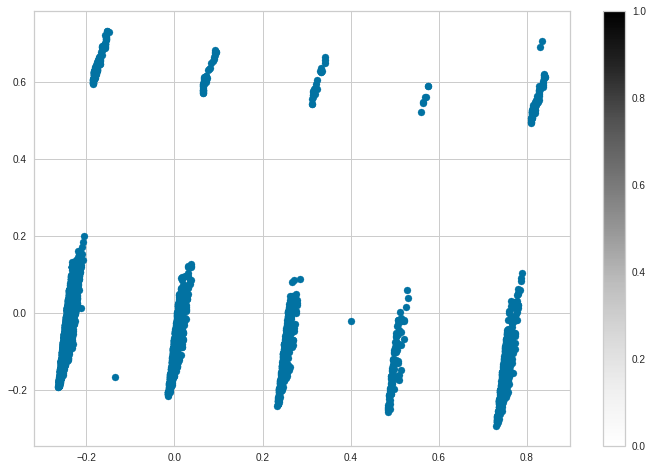

In [53]:
# Projeter les données sur ces 3 composantes principales

plt.figure(figsize=(12,8))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=X.get('rank')) # Afficher chaque observation

plt.colorbar()
plt.show()

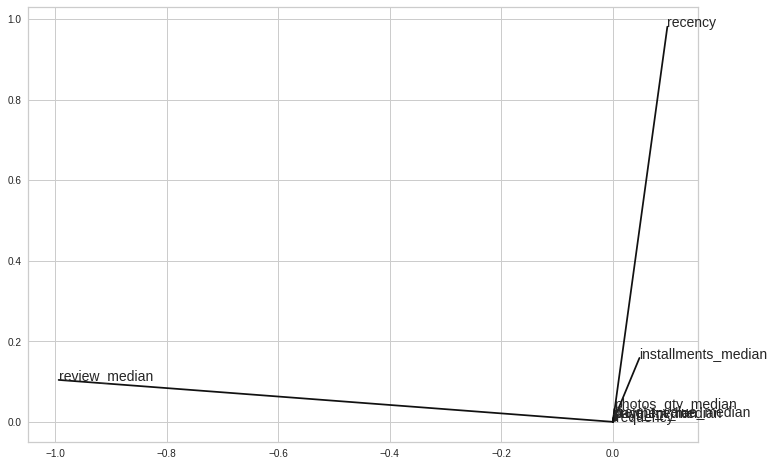

In [54]:
# Contribution de chaque variable aux composantes principales

plt.figure(figsize=(12, 8))
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):    
    plt.plot([0, x], [0, y], color='k') # Afficher un segment de l'origine au point (x, y)
    plt.text(x, y, X.columns[i], fontsize='14') # Afficher le nom (data.columns[i]) de la performance

plt.show()

On constate que les notes et l'ancienneté des clients sont les variables qui génèrent le plus de variance cumulée expliquée.

In [ ]:
assert 2==3

## t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<Figure size 864x576 with 0 Axes>

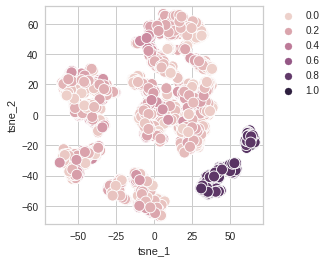

In [57]:
# Application de la TSNE avec 2 dimensions
tsne_result = TSNE(n_components = 2).fit_transform(X_imp)

# Afficher le résultat de la TSNE avec le code couleur du label
plt.figure(figsize=(12, 8))

X = X_imp[:,1]
y = X_imp[:,0]
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)

sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

# 3. MODELISATION


## Sélection du nombre de clusters

## La méthode Elbow 
La méthode Elbow permet de déterminer le nombre idéal de cluster grâce à la zone de coude :
- Cette zone indique que l'ajout de cluster supplémentaire n'augmente plus la variance expliquée de manière aussi importante

In [58]:
def elbow_method (algo, df):
    ''' 
    Instanciation du modèle de clustering et du visualiseur, avec affichage du temps de calcul
       model : algorithme de clustering utilisé
       visualiser : méthode qui permet d'afficher ma méthode d'
    ''' 
    plt.figure(figsize=(12,8))
    model = algo()
    visualizer = KElbowVisualizer(model, k=(2,31), timings=True) # applique la méthode  et affiche la durée de calcul
    visualizer.fit(df)    # Ajuste les données au visualiseur  
    visualizer.poof()    #  Affiche les données
    plt.show()
    return df

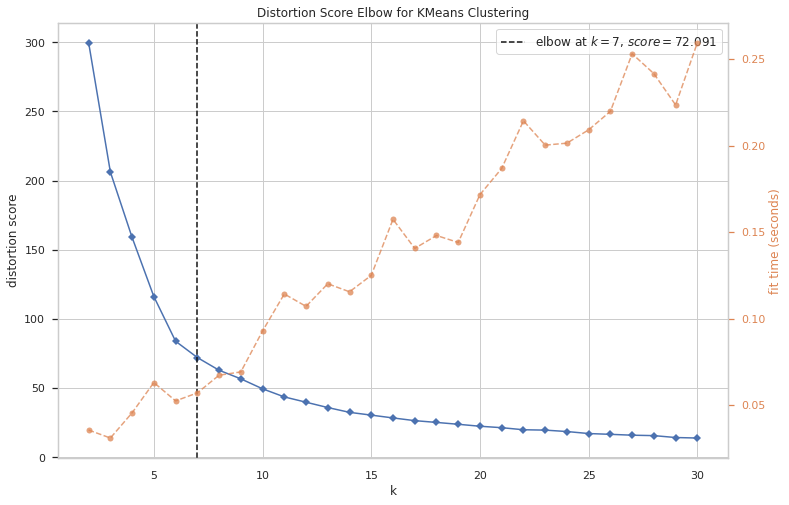

array([[ 0.00853074,  0.01793192, -0.15221626],
       [ 0.49942069, -0.09591235, -0.15283985],
       [ 0.06559019,  0.5893248 , -0.21322995],
       ...,
       [-0.24755704, -0.11851818,  0.19519806],
       [ 0.77770203,  0.03013858,  0.29507736],
       [-0.24907427, -0.04977046, -0.11829028]])

In [61]:
# Application de la fonction elbow_method sur les données réduites par l'ACP 

elbow_method (KMeans, X_projected)

La zone de coude est située à 7 clusters

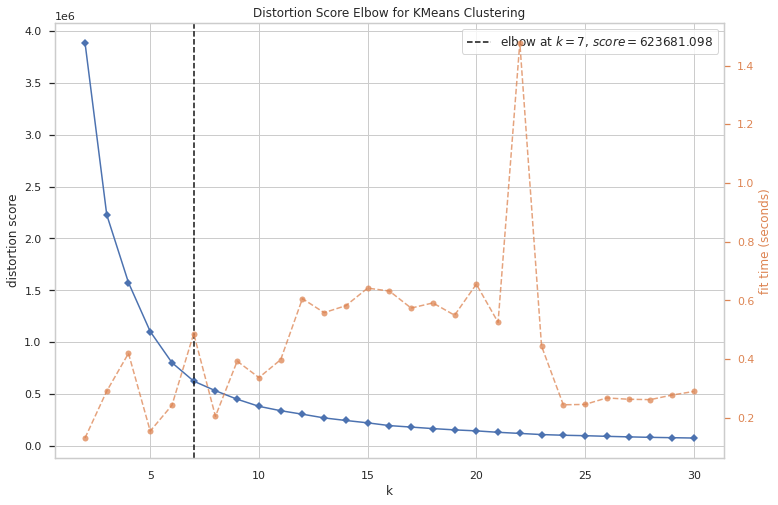

array([[-29.31159 ,  16.94263 ],
       [-22.782337, -53.550034],
       [ 54.081223, -35.40246 ],
       ...,
       [ 22.355026, -11.371326],
       [ -9.598938, -43.026947],
       [ -3.848613,  -9.312095]], dtype=float32)

In [62]:
# Application de la fonction elbow_method sur les données réduites par la t-SNE

elbow_method (KMeans, tsne_result)

- La zone de coude est également située à 7 clusters
- Cela semble indiquer qu'il s'agit du nombre de clusters idéal pour ce dataset en utilisant le kmeans

# 3.1 K-MEANS

## Modelisation avec un benchmark pour calculer l'indice de Rand ajusté

L'indice de Rand ajusté est la proportion de paires de points  qui sont groupées de la même façon dans les deux clusters :

- soit parce que, dans les deux cas, les points appartiennent au même cluster.
- soit parce que, dans les deux cas, les points appartiennent à des clusters différents.

### Avec ACP

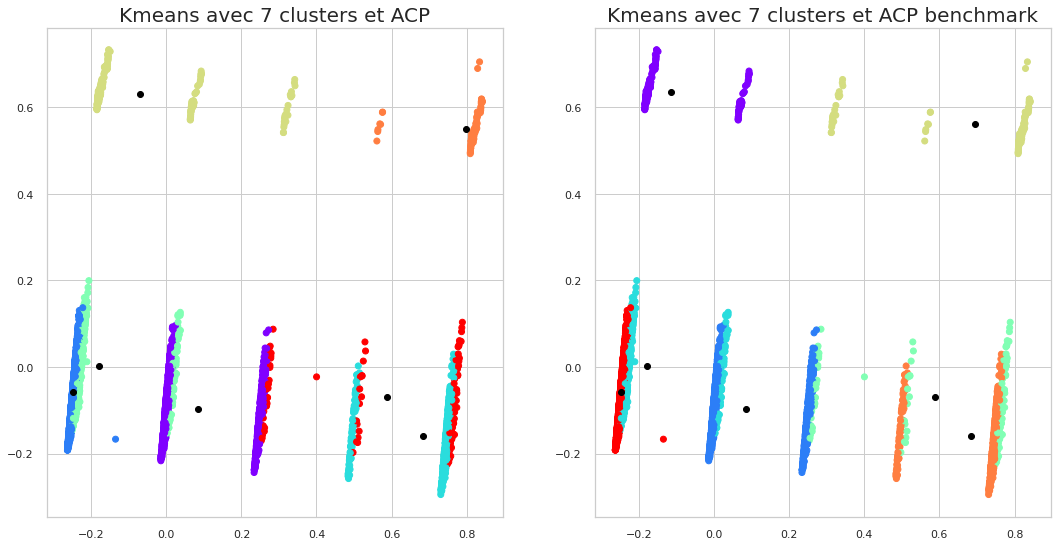

L'indice de Rand AJustée est : 0.9961279509495853


In [69]:
# KMeans via ACP avec 7 clusters
model_2 = KMeans(n_clusters=7, init='k-means++')
model_2.fit(X_projected)
prediction_elbow = model_2.predict(X_projected)

# KMeans via ACP avec 7 clusters, benchmark
model_benchmark = KMeans(n_clusters=7, init='k-means++')
model_benchmark.fit(X_projected)
prediction_elbow_benchmark = model_benchmark.predict(X_projected)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))
plt.title('Kmeans avec 5 clusters et ACP')

plt.subplot(1,2,1)
plt.scatter(X_projected[:,0], X_projected[:,1], c=prediction_elbow, cmap='rainbow')
plt.scatter(model_2.cluster_centers_[:,0], model_2.cluster_centers_[:,1], c='black', label='centroide') # affiche centroides
plt.title('Kmeans avec 7 clusters et ACP', fontsize=20)

plt.subplot(1,2,2)
plt.scatter(X_projected[:,0], X_projected[:,1], c=prediction_elbow_benchmark, cmap='rainbow')
plt.scatter(model_benchmark.cluster_centers_[:,0], model_benchmark.cluster_centers_[:,1], c='black', label='centroide')
plt.title('Kmeans avec 7 clusters et ACP benchmark', fontsize=20)

plt.show()

# Indice de Rand AJustée pour le KMeans via ACP avec 7 clusters
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_elbow, prediction_elbow_benchmark))

### Avec t-SNE

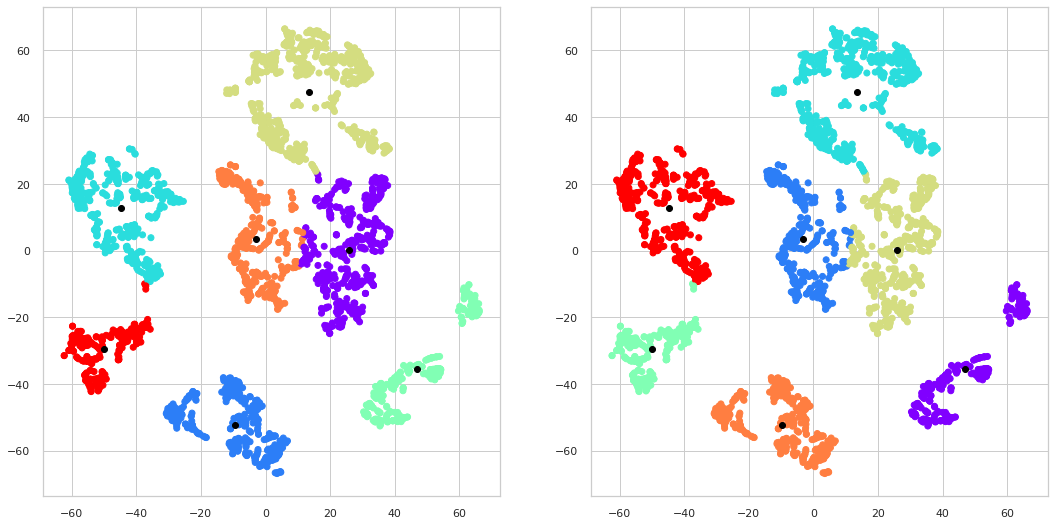

L'indice de Rand AJustée est : 1.0


In [70]:
# KMeans via t-SNE avec 7 clusters
model_3 = KMeans(n_clusters=7,init='k-means++')
model_3.fit(tsne_result)
prediction_tnse_3 = model_3.predict(tsne_result)

# KMeans via t-SNE avec 7 clusters, benchmark
model_benchmark_3 = KMeans(n_clusters=7,init='k-means++')
model_benchmark_3.fit(tsne_result)
prediction_tnse_benchmark_3 = model_benchmark_3.predict(tsne_result)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=prediction_tnse_3, cmap='rainbow')
plt.scatter(model_3.cluster_centers_[:,0], model_3.cluster_centers_[:,1], c='black', label='centroide') # affiche centroides

plt.subplot(1,2,2)
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=prediction_tnse_benchmark_3, cmap='rainbow')
plt.scatter(model_benchmark_3.cluster_centers_[:,0], model_benchmark_3.cluster_centers_[:,1], c='black', label='centroide') 

plt.show()

# Indice de Rand AJustée pour le KMeans via t-NSE avec 9 clusters
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_tnse_3, prediction_tnse_benchmark_3))

## Le coefficient de silhouette
Permet d'évaluer si un point appartient au « bon » cluster :

est-il proche des points du cluster auquel il appartient ?
est-il loin des autres points ?

In [63]:
def metrics_silhouette (algo, data, val, figsize=(15,10)):
    '''
    Affiche le coefficient de silhouette, selon le modèle de clusteringet le df choisit
    '''
    plt.figure(figsize=figsize)
    model = algo(val)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(data)   
    visualizer.poof()
    
    kmeans_model = algo(n_clusters=3, random_state=1).fit(data)
    labels = kmeans_model.labels_
    print('Le coefficient de silhouette est :', metrics.silhouette_score(data, labels, metric='euclidean'))
    
    return data

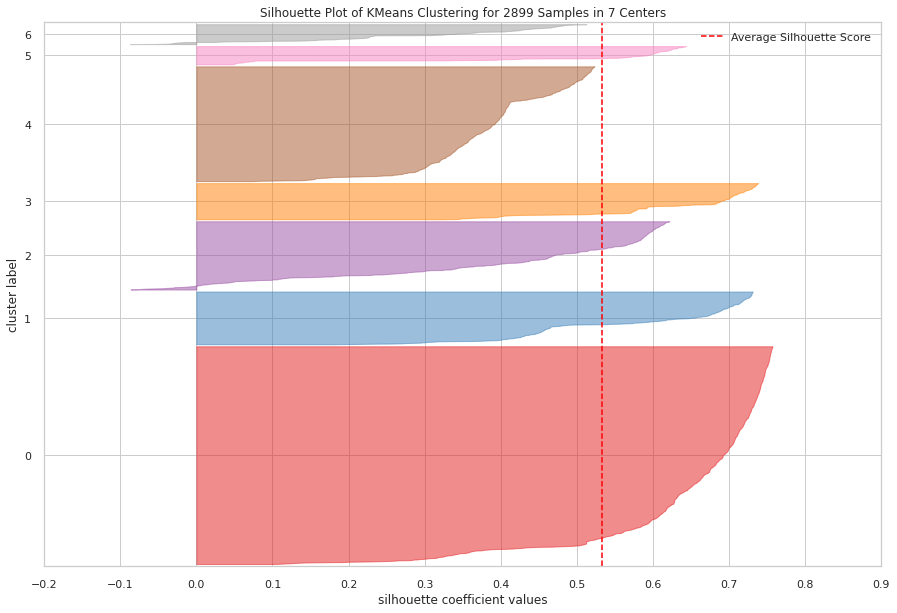

Le coefficient de silhouette est : 0.5638147625404148


array([[ 0.00853074,  0.01793192, -0.15221626],
       [ 0.49942069, -0.09591235, -0.15283985],
       [ 0.06559019,  0.5893248 , -0.21322995],
       ...,
       [-0.24755704, -0.11851818,  0.19519806],
       [ 0.77770203,  0.03013858,  0.29507736],
       [-0.24907427, -0.04977046, -0.11829028]])

In [64]:
# Coefficient de silhouette pour l'ACP avec 7 clusters
metrics_silhouette (KMeans, X_projected, 7)

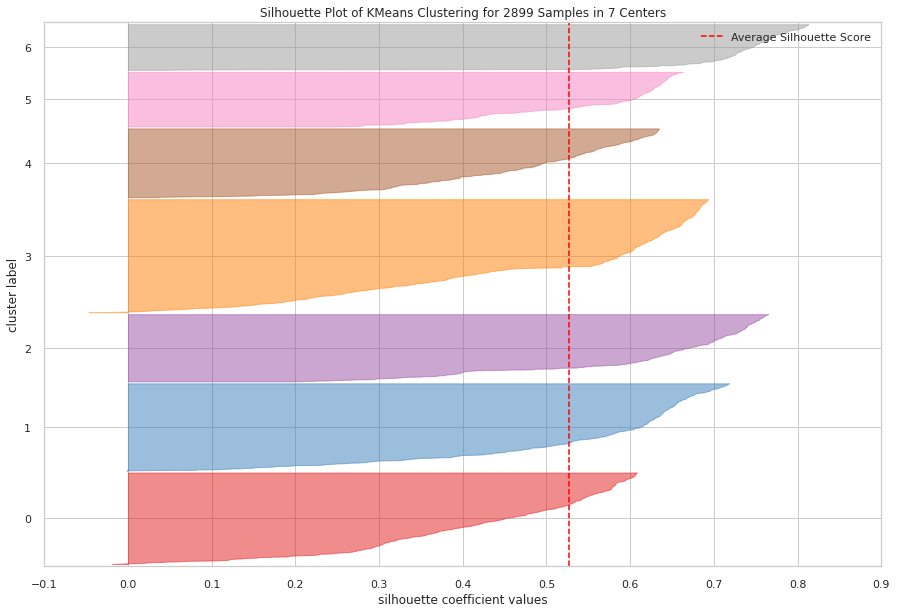

Le coefficient de silhouette est : 0.43657735


array([[-29.31159 ,  16.94263 ],
       [-22.782337, -53.550034],
       [ 54.081223, -35.40246 ],
       ...,
       [ 22.355026, -11.371326],
       [ -9.598938, -43.026947],
       [ -3.848613,  -9.312095]], dtype=float32)

In [65]:
# Coefficient de silhouette pour la t-NSE  avce 7 clusters
metrics_silhouette (KMeans, tsne_result, 7)

- Le coefficient de silhouette est positif dans les 2 cas, ce qui indique que chaque point est en moyenne plus proche de son groupe que du groupe voisin.
- Le coefficient est bien meilleur avec les données réduites par PCA qu'avec les données réduites par t-SNE (0.56 contre 0.43)
- L'ARI est par contre seulement légèrement meilleur avec les données réduites par t-SNE qu'avec celles réduites par PCA l(1.0 contre 0.99)
- Cela indique globalement que la PCA reproduit plus fidelement ses clusters entre différents modèles que la t-SNE.  
- Nous choisirons donc l'ACP pour la suite.

# 3.2 CLUSTERING HIERARCHIQUE

In [71]:
X_projected.shape

(2899, 3)

In [72]:
# Utilisation d'un tiers des données pour le clustering hierarchique

X_projected_10 = X_projected[:1000]

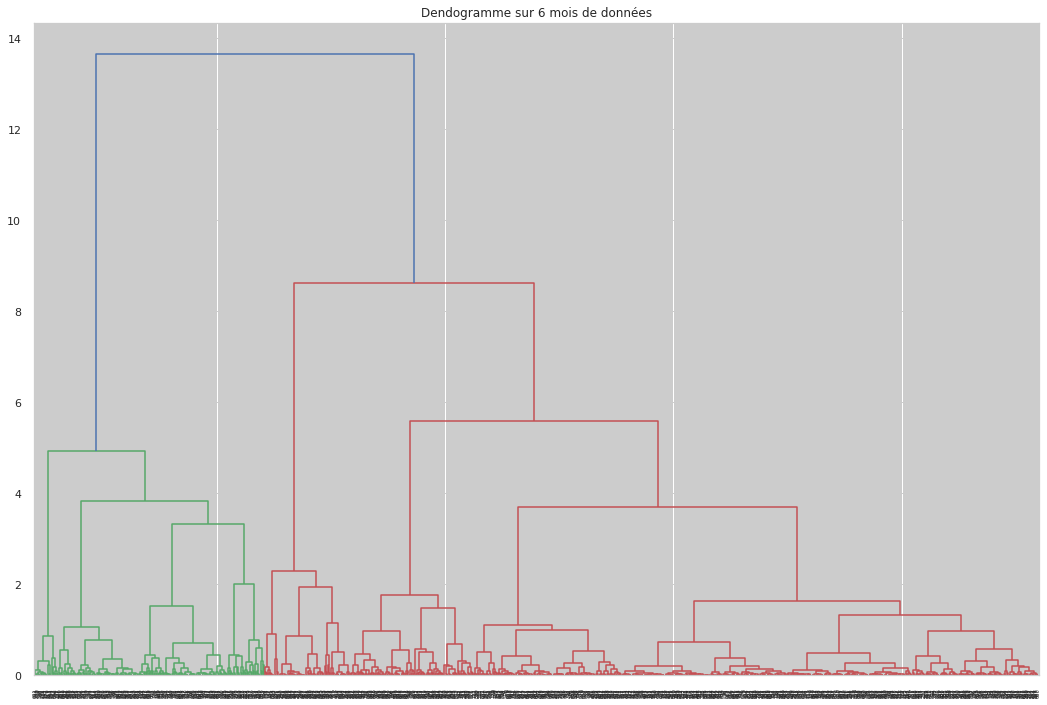

In [73]:
# Affichage d'un Dendogramme pour déterminer le nombre de cluster

plt.figure(figsize=(18, 12))
plt.title("Dendogramme sur les données")
dend = shc.dendrogram(shc.linkage(X_projected_10, method='ward'))

Le dendogramme indique que le nombre de cluster idéal est 5

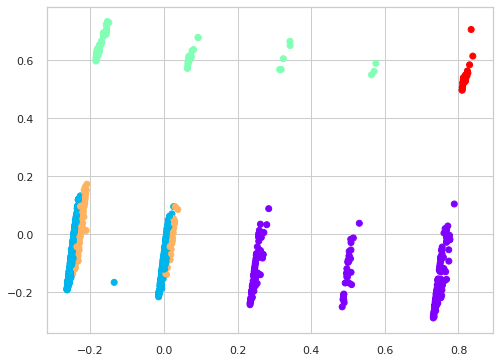

In [75]:
# Création d'un clustering hiérarchique avec 5 clusters
cluster_hierar = AgglomerativeClustering(n_clusters=5).fit(X_projected_10)
cluster_hierar.fit_predict(X_projected_10)
clustering_hierar_prediction = cluster_hierar.fit_predict(X_projected_10)

# Affichage des 5 clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_projected_10[:,0],X_projected_10[:,1], c=cluster_hierar.labels_, cmap='rainbow')
plt.show()

## Méthode d'Elbow 

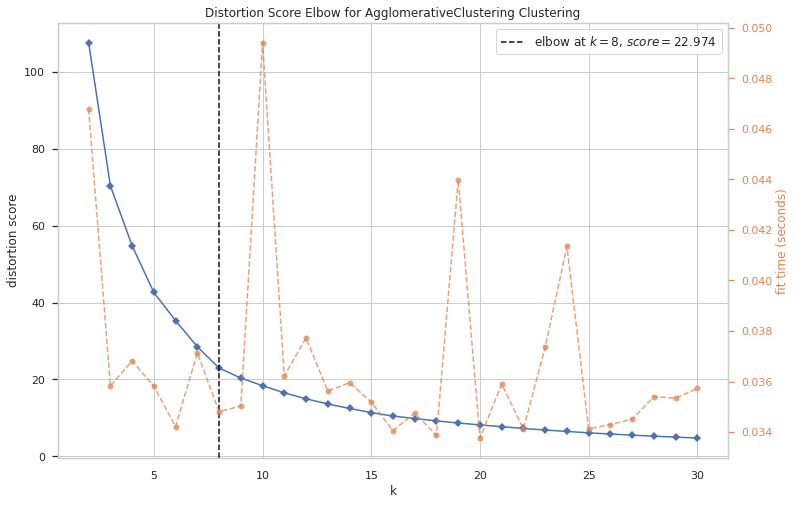

array([[ 0.00853074,  0.01793192, -0.15221626],
       [ 0.49942069, -0.09591235, -0.15283985],
       [ 0.06559019,  0.5893248 , -0.21322995],
       ...,
       [ 0.5081174 , -0.0295981 , -0.10643439],
       [-0.2429902 ,  0.01278508, -0.12546491],
       [-0.24315661,  0.01107742, -0.11198009]])

In [76]:
# Application de la fonction elbow_method sur les données réduites par t-NSE pour l'algorithme hiérarchique
elbow_method (AgglomerativeClustering, X_projected_10)

## Coefficient de silouette

In [78]:
print('Le coefficient de silhouette est :', metrics.silhouette_score(X_projected_10, 
                                                                     clustering_hierar_prediction, 
                                                                     metric='euclidean'))

Le coefficient de silhouette est : 0.5066075932190878


## Indice de Rand ajusté (ARI)

In [79]:
# Création d'un clustering hiérarchisé avec 5 clusters comme benchmark
cluster_hierar_bench = AgglomerativeClustering(n_clusters=5).fit(X_projected_10)
cluster_hierar_bench.fit_predict(X_projected_10)
clustering_hierar_prediction_bench = cluster_hierar_bench.fit_predict(X_projected_10)

# Indice de Rand AJustée pour le clustering hiérarchisé via ACP 
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(clustering_hierar_prediction,
                                                                   clustering_hierar_prediction_bench))

L'indice de Rand AJustée est : 1.0


# 3.3 CLUSTERING PAR DENSITE (DBSCAN)

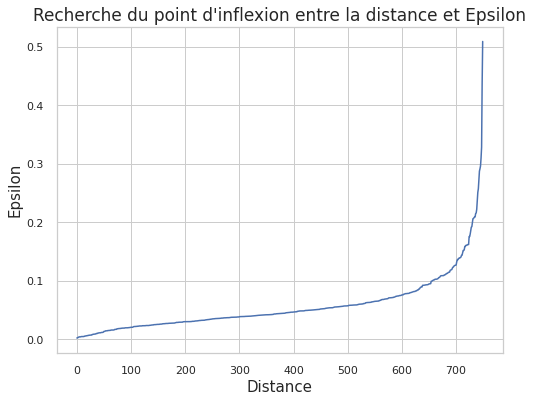

In [81]:
X = X_projected
X, labels_true = make_blobs(n_samples=750, cluster_std=0.4, random_state=0)

# Calcul des distances
nn = NearestNeighbors(n_neighbors=7).fit(X) 
distances, idx = nn.kneighbors(X) 
distances = np.sort(distances, axis=0) # Trie des distances par order croissant

# Affiche le graphique entre la distance et epsilon
distances = distances [:,1] 
plt.figure(figsize=(8, 6)) 
plt.plot(distances) 
plt.title("Recherche du point d'inflexion entre la distance et Epsilon", fontsize=17)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Epsilon', fontsize=15)
plt.show()

On constate que le point d'inflexion est situé vers 0.15 epsilon

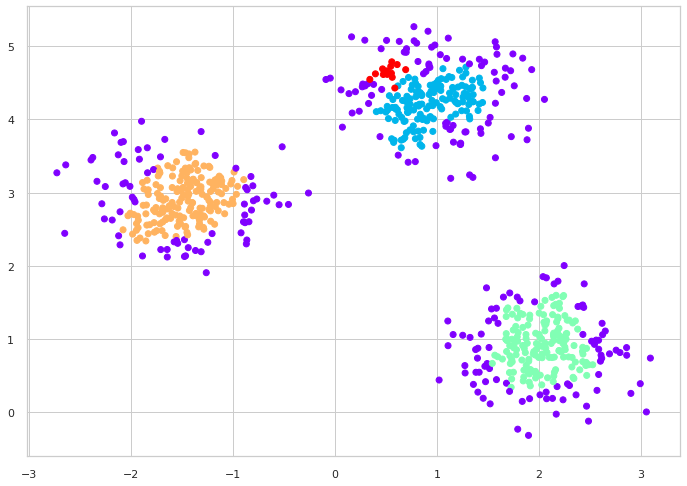

In [82]:
model = DBSCAN(eps=0.15, min_samples=10)
model.fit(X)
labels = model.labels_

plt.scatter(X[:,0], X[:,1], c=labels, cmap = 'rainbow')

##  Coefficient de silhouette

In [83]:
print('Le coefficient de silhouette est :', metrics.silhouette_score(X, labels))

Le coefficient de silhouette est : 0.20488432935962475


## Indice de Rand ajusté (ARI)

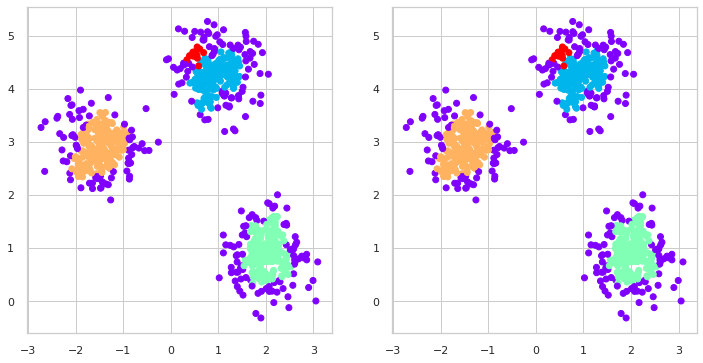

L'indice de Rand AJustée est : 1.0


In [86]:
# Modèle pour benchmark
model_benchmark = DBSCAN(eps=0.15, min_samples=10)
model_benchmark.fit(X)
labels_benchmark = model_benchmark.labels_

# Visualisation des clusters
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=labels, cmap = 'rainbow')

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=labels_benchmark, cmap = 'rainbow')

plt.show()

# Indice de Rand AJustée pour le DBSCAN via ACP 
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(labels, labels_benchmark))

- L'ARI de 1 indique que les clusters sont identiques , mais la différence avec les 0.99 du kmeans est minime.

- Le coefficient de silhouette est presque 2 fois  inférieur à celui du K-Means avec 0.20 contre 0.39.


Le modèle retenu est donc le kmeans avec 5 clusters et ACP.


## Modèle retenu : KMEANS, avec PCA et 5 Clusters

# 4. SEGMENTATION PAR TYPES DE CLUSTERS 

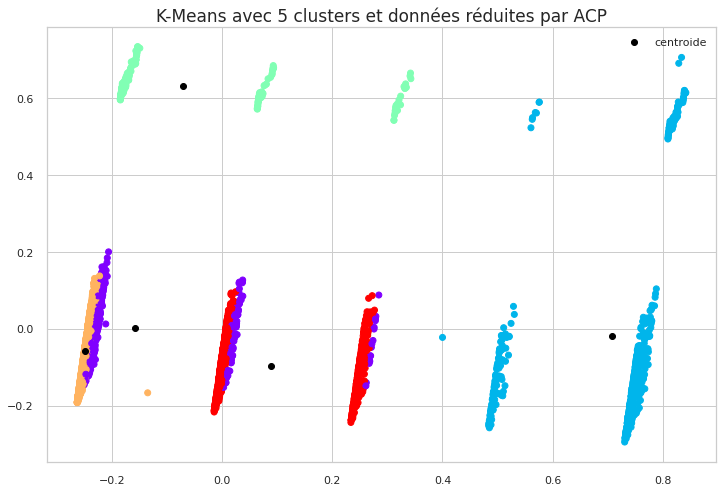

In [87]:
model = KMeans(n_clusters=5, init='k-means++')

model.fit(X_projected)
clusterisation = model.predict(X_projected)


plt.figure(figsize=(12,8))
plt.scatter(X_projected[:,0], X_projected[:,1], c=clusterisation, cmap='rainbow')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='black', label='centroide') # affiche les centroides
plt.title('K-Means avec 5 clusters et données réduites par ACP', fontsize=17)
plt.legend()
plt.show()

In [88]:
# Ajout d'une feature pour connaitre le cluster de chaque client
df['cluster'] = clusterisation

# Groupby sur les clusters
customer_by_cluster = df.groupby('cluster')

ValueError: ignored

In [89]:
df.describe() #permet de choisir les segments de clients selon les quartiles

,recency,frequency,payment_median,price_median,installments_median,freight_value_median,review_median,photos_qty_median
count,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,241.744250,1.033406,158.582579,126.264014,2.906672,20.251332,4.104078,2.254063
std,153.164721,0.208235,217.640857,190.058200,2.685834,15.866087,1.327166,1.738960
min,0.000000,1.000000,0.250000,0.850000,0.000000,0.000000,1.000000,1.000000
25%,118.000000,1.000000,60.750000,42.790000,1.000000,13.370000,4.000000,1.000000
50%,222.000000,1.000000,103.550000,79.000000,2.000000,16.430000,5.000000,2.000000
75%,351.000000,1.000000,175.572500,139.900000,4.000000,21.250000,5.000000,3.000000
max,728.000000,15.000000,13664.080000,6735.000000,24.000000,409.680000,5.000000,20.000000


Nombre de clients satisfait: 53999
Nombre de clients fréquents: 2807
Nombre de bons clients : 5934
Nombre de clients perdus: 18


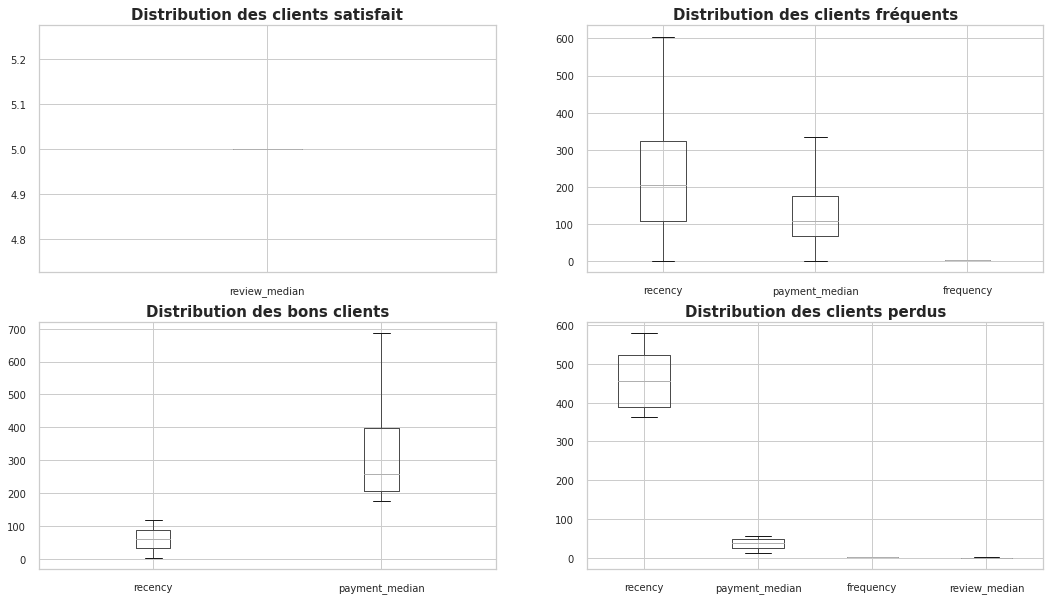

In [111]:
# Création de features basése sur les segments de clients

# Clients satisfaits : clients ayant donné une note de 5
df['satisfied_customer'] = np.where((df['review_median'] == 5), 1, 0) 

# Clients fidèles :  clients avec un minimum de 2 achats différents
df['frequent_customer'] = np.where((df['frequency'] > 1), 1, 0) 

# Bons clients : clients avec de grosses dépenses et recents
df['good_customer'] = np.where((df['payment_median'] > 175) & (df['recency'] < 118), 1, 0)


# Clients perdus : clients avec de faibles dépenses, anciens, pas fidèles et insatisfaits
df['lost_customer'] = np.where((df['payment_median'] < 60) & (df['recency'] > 351) & (df['frequency'] == 1) 
                       & (df['review_median'] < 3), 1, 0)

# Visualisation des différents segments de clients

# Clients satisfaits : clients ayant donné une note de 5
satisfied_customer = df.loc[df['review_median'] == 5]

# Clients fidèles :  clients avec un minimum de 2 achats différents
frequent_customer = df.loc[df['frequency'] > 1] # clients avec un minimum de 2 achats différents

# Bons clients : clients avec de grosses dépenses et recents
good_customer = df.loc[(df['payment_median'] > 175) & (df['recency'] < 118)] 

# Clients perdus : clients avec de faibles dépenses, anciens, pas fidèles et insatisfaits
lost_customer = df.loc[(df['payment_median'] < 60) & (df['recency'] > 351) & (df['frequency'] > 1) 
                       & (df['review_median'] < 3)] 

print('Nombre de clients satisfait:',satisfied_customer['review_median'].count())
print('Nombre de clients fréquents:', frequent_customer['frequency'].count())
print('Nombre de bons clients :', good_customer['payment_median'].count())
print('Nombre de clients perdus:', lost_customer['payment_median'].count())

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
satisfied_customer = satisfied_customer[['review_median']]
satisfied_customer.boxplot(showfliers=False)
plt.title('Distribution des clients satisfait', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.subplot(2,2,2)
frequent_customer = frequent_customer[['recency', 'payment_median', 'frequency']]
frequent_customer.boxplot(showfliers=False)
plt.title('Distribution des clients fréquents', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.subplot(2,2,3)
good_customer = good_customer[['recency', 'payment_median']]
good_customer.boxplot(showfliers=False)
plt.title('Distribution des bons clients', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.subplot(2,2,4)
lost_customer = lost_customer[['recency', 'payment_median', 'frequency', 'review_median']]
lost_customer.boxplot(showfliers=False)
plt.title('Distribution des clients perdus', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

- les bons clients types et les clients VIP ont des dépenses plus importantes que la moyenne et ont commandé dans les 3 derniers mois.
- les clients à ne pas cibler et les clients perdus ont des montantd de commande peu élevés et n'ont pas commandé depuis plus d'un an.
- les clients types et les clients fréquents ont des dépense et une ancienneté qui se situent entre ces 2 groupes.

In [92]:
# Nombre de clients totaux par cluster
customer_by_cluster['cluster'].count()

NameError: ignored

In [ ]:
# Nombre de client par segment pour chaque cluster
customer_by_cluster['satisfied_customer', 'frequent_customer',  'good_customer',  
                 'lost_customer'].sum()

- Le Cluster 0 est constitué en divers types de clients.
-  Le cluster 1 est constitué en grande majorité de clients satisfait.
- Le cluster 2 est constitué en intégralité de clients de clients satisfait.
- Le cluster 3 est constitué en grande partie de bons clients, ainsi que de clients satisfait
- Le cluster 4 est constitué en intégralité des clients perdus .

In [93]:
# Statistiques sur le montant, la fréquence et l'ancienneté des commandes pour chaque cluster
customer_by_cluster['payment_median', 'recency', 'frequency'].agg(['min', 'max', 'mean', 'median'])

NameError: ignored

Montant, ancienneté et fréquence des commandes :

- Au niveau des commandes, le cluster 3 (majoritairement des bons clients ) à comme attendu les commandes moyennes (384RB) et  médianes (259RB) les plus importantes.

- Au niveau de l’ancienneté des commandes, le cluster 3 (majoritairement des bons clients) à également les commandes moyennes (61) et  médianes (60) les plus récentes.


- Au niveau de la fréquence des commandes, les cluster 0 et 4 ont les clients les plus fidèles. Ces données sont à prendre avec des pincettes car 97% des clients n’ont fait qu’une seule commandes.


Conclusion sur la segmentation :

- Le modèle à parfaitement su distinguer les différents types de clients.
- Comme attendu, il est préférable de cibler en priorité les bons clients du clusters 3, ceux  qui dépensent le plus, sont le plus fidèle et ont réalisé les commandes les plus récentes.
- Les clients fidèles et/ou satisfait des clusters 1 et 2 sont également à cibler.
- Les clients des clusters 4 doivent à tout pris être évités. En plus de dépenser peu et d'avoir des commandes anciennes, ces clients ne sont jamais revenu et leurs satisfaction (mesurée par les notes données) est beaucoup plus faibles que la moyenne.

# 5. RECHERCHE DE LA FREQUENCE IDEALE DE SEGMENTATION 

## Avec 1 mois de données

In [94]:
# Réduction de dimensions avec APC
pca_1 = decomposition.PCA(n_components = 3)
pca_1.fit(X_imp1)

# Création d'un df des données transformées par l'APC
X_projected_1 = pca_1.transform(X_imp1)
X_projected_1.shape

(11, 3)

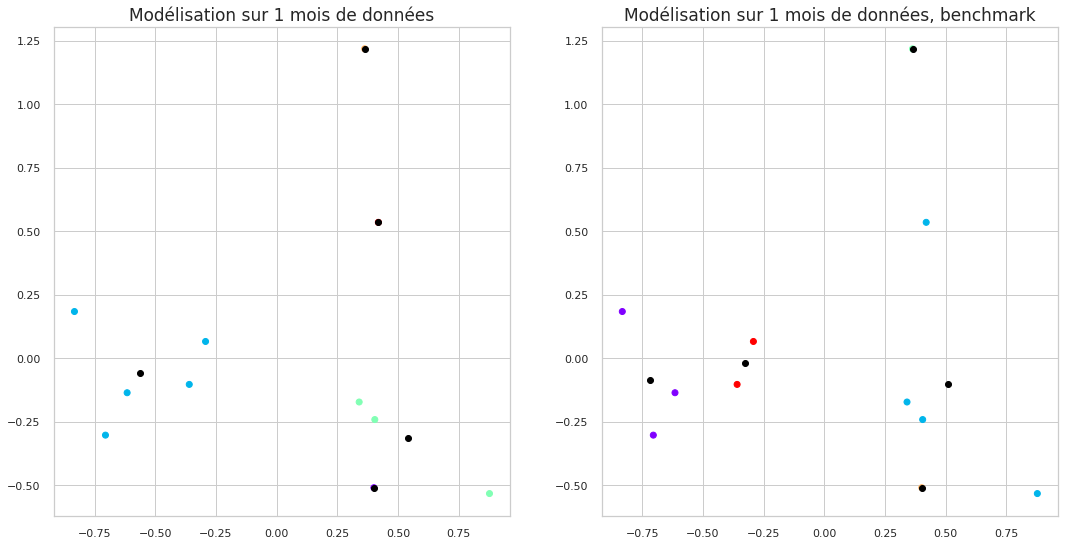

L'indice de Rand AJustée est : 0.5074626865671642


In [95]:
# KMeans via ACP 
model_1_months = KMeans(n_clusters=5,init='k-means++')
model_1_months.fit(X_projected_1)
prediction_1_months = model_1_months.predict(X_projected_1)

# KMeans via ACP benchmark
model_1_months_bench = KMeans(n_clusters=5,init='k-means++')
model_1_months_bench.fit(X_projected_1)
prediction_1_months_bench = model_1_months_bench.predict(X_projected_1)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(X_projected_1[:,0], X_projected_1[:,1], c=prediction_1_months, cmap='rainbow')
plt.scatter(model_1_months.cluster_centers_[:,0], model_1_months.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 1 mois de données', fontsize=17)

plt.subplot(1,2,2)
plt.scatter(X_projected_1[:,0], X_projected_1[:,1], c=prediction_1_months_bench, cmap='rainbow')
plt.scatter(model_1_months_bench.cluster_centers_[:,0], model_1_months_bench.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 1 mois de données, benchmark', fontsize=17)

plt.show()

# Indice de Rand AJustée 

print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_1_months, prediction_1_months_bench))

# Avec 2 mois de données

In [96]:
# Réduction de dimensions avec APC
pca_2 = decomposition.PCA(n_components = 3)
pca_2.fit(X_imp2)

# Création d'un df des données transformées par l'APC
X_projected_2 = pca_2.transform(X_imp2)
X_projected_2.shape

(300, 3)

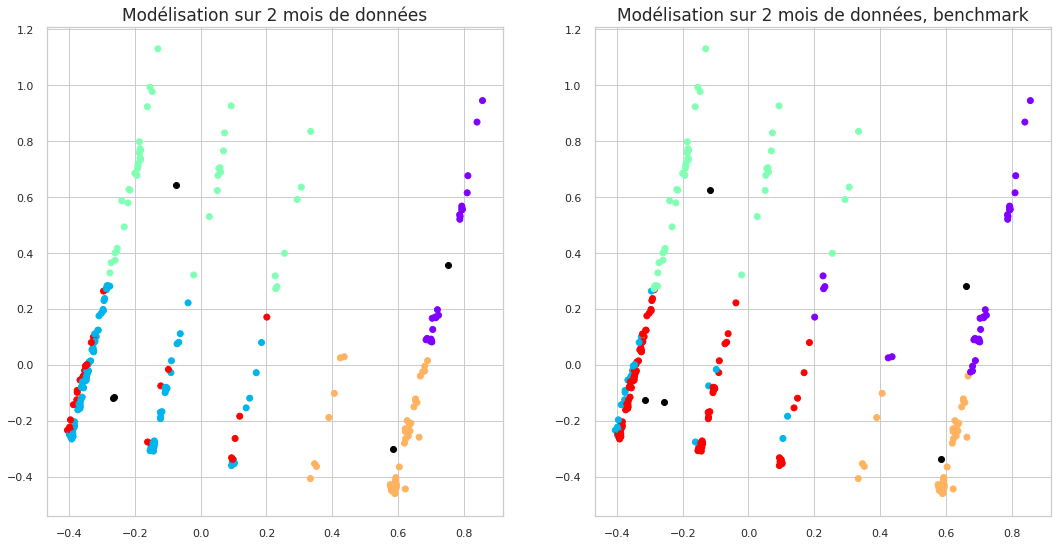

L'indice de Rand AJustée est : 0.8595223470853466


In [97]:
# KMeans via ACP 
model_2_months = KMeans(n_clusters=5,init='k-means++')
model_2_months.fit(X_projected_2)
prediction_2_months = model_2_months.predict(X_projected_2)

# KMeans via ACP  benchmark
model_2_months_bench = KMeans(n_clusters=5,init='k-means++')
model_2_months_bench.fit(X_projected_2)
prediction_2_months_bench = model_2_months_bench.predict(X_projected_2)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(X_projected_2[:,0], X_projected_2[:,1], c=prediction_2_months, cmap='rainbow')
plt.scatter(model_2_months.cluster_centers_[:,0], model_2_months.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 2 mois de données', fontsize=17)

plt.subplot(1,2,2)
plt.scatter(X_projected_2[:,0], X_projected_2[:,1], c=prediction_2_months_bench, cmap='rainbow')
plt.scatter(model_2_months_bench.cluster_centers_[:,0], model_2_months_bench.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 2 mois de données, benchmark', fontsize=17)

plt.show()

# Indice de Rand AJustée
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_2_months, prediction_2_months_bench))

## Avec 3 mois de données

In [98]:
# Réduction de dimensions avec APC
pca_3 = decomposition.PCA(n_components = 3)
pca_3.fit(X_imp3)

# Création d'un df des données transformées par l'APC
X_projected_3 = pca_3.transform(X_imp3)
X_projected_3.shape

(300, 3)

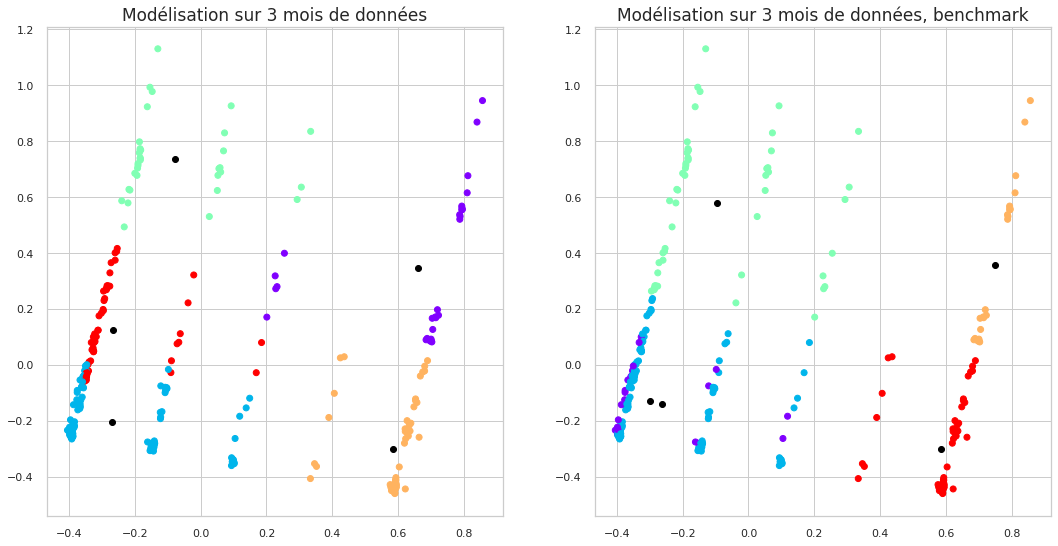

L'indice de Rand AJustée est : 0.5536869713226555


In [99]:
# KMeans via ACP 
model_3_months = KMeans(n_clusters=5,init='k-means++')
model_3_months.fit(X_projected_3)
prediction_3_months = model_3_months.predict(X_projected_3)

# KMeans via ACP benchmark
model_3_months_bench = KMeans(n_clusters=5,init='k-means++')
model_3_months_bench.fit(X_projected_3)
prediction_3_months_bench = model_3_months_bench.predict(X_projected_3)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(X_projected_3[:,0], X_projected_3[:,1], c=prediction_3_months, cmap='rainbow')
plt.scatter(model_3_months.cluster_centers_[:,0], model_3_months.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 3 mois de données', fontsize=17)

plt.subplot(1,2,2)
plt.scatter(X_projected_3[:,0], X_projected_3[:,1], c=prediction_3_months_bench, cmap='rainbow')
plt.scatter(model_3_months_bench.cluster_centers_[:,0], model_3_months_bench.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 3 mois de données, benchmark', fontsize=17)

plt.show()

# Indice de Rand AJustée 
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_3_months, prediction_3_months_bench))

## Avec 4 mois de données

In [100]:
# Réduction de dimensions avec APC
pca_4 = decomposition.PCA(n_components = 3)
pca_4.fit(X_imp4)

# Création d'un df des données transformées par l'APC
X_projected_4 = pca_4.transform(X_imp4)
X_projected_4.shape

(300, 3)

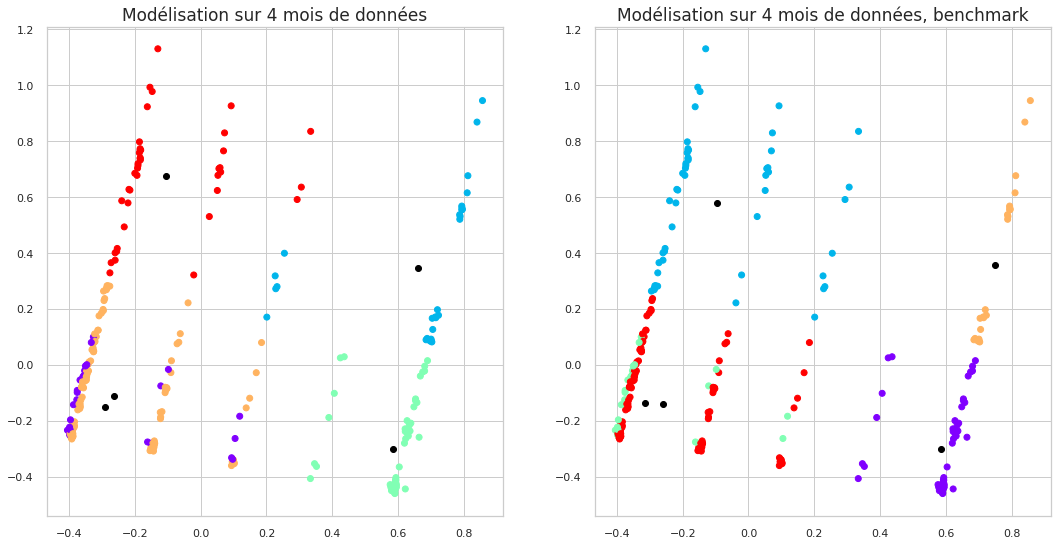

L'indice de Rand AJustée est : 0.8866556903062427


In [101]:
# KMeans via ACP 
model_4_months = KMeans(n_clusters=5,init='k-means++')
model_4_months.fit(X_projected_4)
prediction_4_months = model_4_months.predict(X_projected_4)

# KMeans via ACP benchmark
model_4_months_bench = KMeans(n_clusters=5,init='k-means++')
model_4_months_bench.fit(X_projected_4)
prediction_4_months_bench = model_4_months_bench.predict(X_projected_4)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(X_projected_4[:,0], X_projected_4[:,1], c=prediction_4_months, cmap='rainbow')
plt.scatter(model_4_months.cluster_centers_[:,0], model_4_months.cluster_centers_[:,1], c='black', label='centroide')
plt.title('Modélisation sur 4 mois de données', fontsize=17)

plt.subplot(1,2,2)
plt.scatter(X_projected_4[:,0], X_projected_4[:,1], c=prediction_4_months_bench, cmap='rainbow')
plt.scatter(model_4_months_bench.cluster_centers_[:,0], model_4_months_bench.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 4 mois de données, benchmark', fontsize=17)

plt.show()

# Indice de Rand AJustée 
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_4_months, prediction_4_months_bench))

## Avec 5 mois de données

In [102]:
# Réduction de dimensions avec APC
pca_5 = decomposition.PCA(n_components = 3)
pca_5.fit(X_imp5)

# Création d'un df des données transformées par l'APC
X_projected_5 = pca_5.transform(X_imp5)
X_projected_5.shape

(1218, 3)

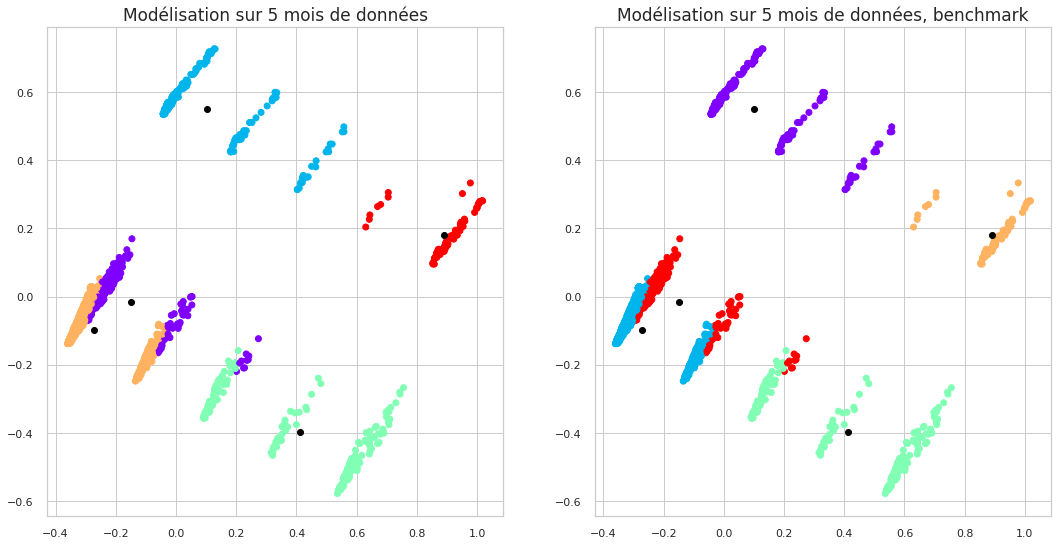

L'indice de Rand AJustée est : 1.0


In [103]:
# KMeans via ACP 
model_5_months = KMeans(n_clusters=5,init='k-means++')
model_5_months.fit(X_projected_5)
prediction_5_months = model_5_months.predict(X_projected_5)

# KMeans via ACP benchmark
model_5_months_bench = KMeans(n_clusters=5,init='k-means++')
model_5_months_bench.fit(X_projected_5)
prediction_5_months_bench = model_5_months_bench.predict(X_projected_5)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(X_projected_5[:,0], X_projected_5[:,1], c=prediction_5_months, cmap='rainbow')
plt.scatter(model_5_months.cluster_centers_[:,0], model_5_months.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 5 mois de données', fontsize=17)

plt.subplot(1,2,2)
plt.scatter(X_projected_5[:,0], X_projected_5[:,1], c=prediction_5_months_bench, cmap='rainbow')
plt.scatter(model_5_months_bench.cluster_centers_[:,0], model_5_months_bench.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 5 mois de données, benchmark', fontsize=17)

plt.show()

# Indice de Rand AJustée 
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_5_months, prediction_5_months_bench))

# Avec 6 mois de données

In [104]:
# Réduction de dimensions avec APC
pca_6 = decomposition.PCA(n_components = 3)
pca_6.fit(X_imp6)

# Création d'un df des données transformées par l'APC
X_projected_6 = pca_6.transform(X_imp6)
X_projected_6.shape

(2899, 3)

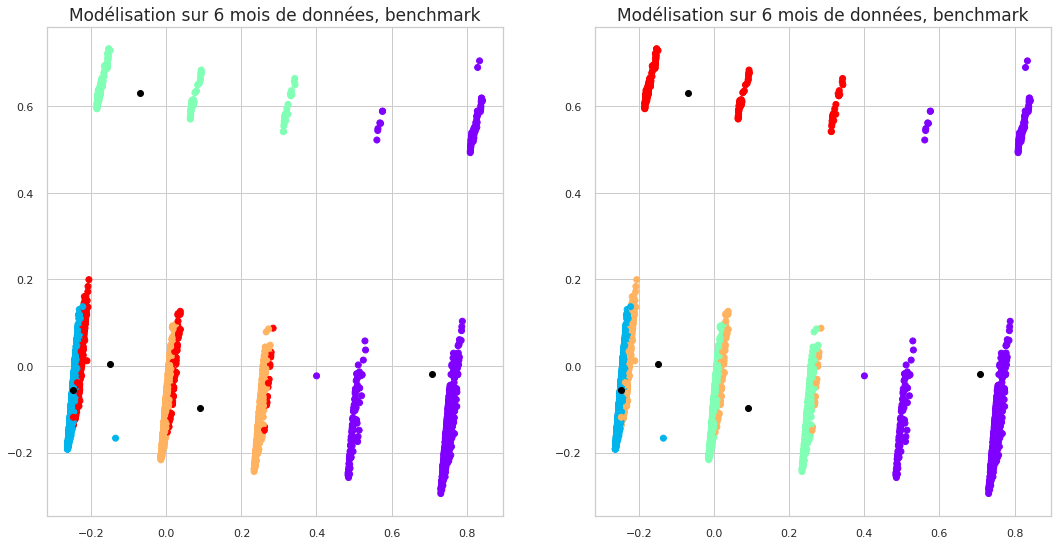

L'indice de Rand AJustée est : 1.0


In [105]:
# KMeans via ACP
model_6_months = KMeans(n_clusters=5,init='k-means++')
model_6_months.fit(X_projected_6)
prediction_6_months = model_6_months.predict(X_projected_6)

# KMeans via ACP benchmark
model_6_months_bench = KMeans(n_clusters=5,init='k-means++')
model_6_months_bench.fit(X_projected_6)
prediction_6_months_bench = model_6_months_bench.predict(X_projected_6)

# Visualisation des 2 clusters
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.scatter(X_projected_6[:,0], X_projected_6[:,1], c=prediction_6_months, cmap='rainbow')
plt.scatter(model_6_months.cluster_centers_[:,0], model_6_months.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 6 mois de données, benchmark', fontsize=17)

plt.subplot(1,2,2)
plt.scatter(X_projected_6[:,0], X_projected_6[:,1], c=prediction_6_months_bench, cmap='rainbow')
plt.scatter(model_6_months_bench.cluster_centers_[:,0], model_6_months_bench.cluster_centers_[:,1], c='black', label='centroide') 
plt.title('Modélisation sur 6 mois de données, benchmark', fontsize=17)

plt.show()

# Indice de Rand AJustée 
print("L'indice de Rand AJustée est :",metrics.adjusted_rand_score(prediction_6_months, prediction_6_months_bench))

<Figure size 1800x864 with 0 Axes>

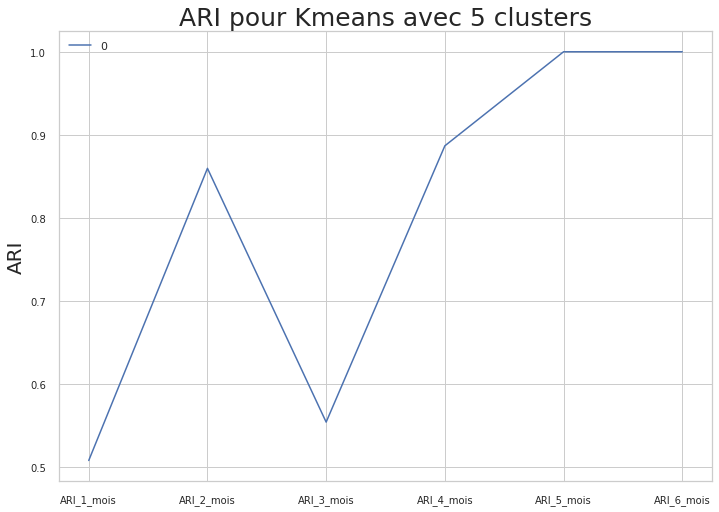

In [106]:
# Création d'un df regroupant les ARI 
ARI_1 = metrics.adjusted_rand_score(prediction_1_months, prediction_1_months_bench)
ARI_2 = metrics.adjusted_rand_score(prediction_2_months, prediction_2_months_bench)
ARI_3 = metrics.adjusted_rand_score(prediction_3_months, prediction_3_months_bench)
ARI_4 = metrics.adjusted_rand_score(prediction_4_months, prediction_4_months_bench)
ARI_5 = metrics.adjusted_rand_score(prediction_5_months, prediction_5_months_bench)
ARI_6 = metrics.adjusted_rand_score(prediction_6_months, prediction_6_months_bench)

df_ARI = pd.DataFrame({'ARI_1_mois': [ARI_1], 
                       'ARI_2_mois': [ARI_2],
                       'ARI_3_mois': [ARI_3],
                       'ARI_4_mois': [ARI_4],
                       'ARI_5_mois': [ARI_5],
                       'ARI_6_mois': [ARI_6] 
                      })
df_ARI = df_ARI.T

# Affichage du df
plt.figure(figsize=(25,12))

df_ARI.plot()
plt.title( "ARI pour Kmeans avec 5 clusters", fontsize=25 ) 
plt.ylabel( 'ARI', fontsize=20 ) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [107]:
df_ARI

,0
ARI_1_mois,0.507463
ARI_2_mois,0.859522
ARI_3_mois,0.553687
ARI_4_mois,0.886656
ARI_5_mois,1.000000
ARI_6_mois,1.000000


Conclusion sur la fréquence de segmentation :

- Le premier mois ne contient pas assez de données pour être pris en compte et son ARi est faible.
- La fréquence de segmentation idéale est donc de 2 mois, avec un ARI de 0.85.
- On constate qu'au 3ème mois l'ARI chute de 34 points en passant de 0.88 à 0.54.
- L' ARI redevient supérieur à 0.80 lors des 3èmes, 4èmes et 5èmes mois et ne repasse sous à 0.8 qu'au 6ème mois.
- L'avantage d'utiliser une fréquence courte (2 mois), plutot qu'une fréquence longue (5 mois) est de surfer sur les tendances du marché en resegmentant fréquement le dataset. Cela permet de devancer ses concurents qui utiliseraient une fréquence plus longue.

# 6. CONCLUSION 

- Pour réduire les dimensions il faut utiliser l'ACP.
- Pour modéliser le phénomène il faut utiliser l'algorithme du kmeans avec comme hyperparamètres 5 clusters et règlés sur 'kmeans++'.
- Cet algorithme (kmeans avec ACP et 5 clusters, réglés sur sur 'kmeans++' donne un meilleur ARI et un meilleur coefficient de silouette que tous les autres modèles.
- Il est préférable de cibler en priorité les bons clients du clusters 3, ceux qui dépensent le plus, sont le plus fidèle et ont réalisé les commandes les plus récentes.
- Les clients fidèles et/ou satisfait des clusters 1 et 2 sont également à cibler.
- La segmentation doit etre remodéliser tous les 2 mois. 
- On constate que cette fréquence à le point de bascule idéal pour créér de nouvelles segmentations.
- En fonction des données, et donc du comportement des clients lors du mois précédent, le nombre de clusters pourra varier d'un modèle à l'autre.